# End-to-end DSPy Workflows Guide 

Time to complete: 1.5 hours

## Building an Efficient LLM Pipeline with DSPy and Anyscale

In this guide, we'll show how you can build an efficient pipeline covering synthetic data generation, data processing, fine-tuning, evaluation and serving with DSPy and Anyscale.

**What is DSPy?**

DSPy is a framework for building and optimizing programs involving language models.

It allows you to define a complex pipeline with simple Python code, and then optimize the pipeline for better performance on whatever your task is.

See the [DSPy Documentation](https://dspy-docs.vercel.app/intro/) for more information.

## Why DSPy and Anyscale?
DSPy simplifies the complex workflow of:
- Data Collection/Labeling
- Fine-tuning
- Prompt Optimization
- Evaluation
  
We'll use Anyscale for scalable infrastructure for training and serving/deploying models.

## Scenario: Cost-Effective Customer Support Query Classification

Consider an example of classification with limited labelled data. The specific dataset we'll be working with is the [PolyAI/banking77](https://huggingface.co/datasets/PolyAI/banking77) dataset, which consists of customer support queries for a bank. We'll simulate a scenario with low labelled data: let's say we have a dataset has limited labeled data (100 queries) and 4,000 unlabeled customer queries. We'll build a solution that leverages DSPy on Anyscale to distill knowledge from a 70B model into a more cost-effective 1B model, making it practical for production deployment.

- DSPy enables easy creation of a pipeline for knowledge distillation from a 70B model to a 1B model in a low data environment
- Anyscale's infrastructure supports efficient fine-tuning and deployment
- Result: A cost-effective, accurate classification system for 25 categories

## Table of Contents

1. Setup
2. Data Processing and Labeling
3. Model Fine-tuning
4. Evaluation and Optimization
5. Production Deployment
6. Future Improvements

## Set up

We will be running everything on A100-80GB GPUs. This is not necessary, especially for running a 1B model. You can edit the serving configuration files used throughout the notebook to use different GPUs if you do not have access to A100s.

We use Anyscale's Auto-select worker node feature to launch and manage child nodes that are running our LLM. You can also set your own compute configuration to autoscale different types of GPUs at different ranges.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib.util

if importlib.util.find_spec("dspy") is None:
    print("Installing dspy")
    !pip install git+https://github.com/stanfordnlp/dspy.git@main

else:
    print("dspy is already installed")

!pip install matplotlib python-dotenv

dspy is already installed


In [3]:
import dspy
dspy.settings.configure(experimental=True)

import ujson

from src import set_dspy_cache_location
set_dspy_cache_location("/home/ray/default/dspy/cache")

In order to run this notebook, you need to have the following environment variables set:
- HF_HOME=/mnt/local_storage/huggingface (By default, the cache directory used by HuggingFace is in the home directory -`/home/ray` in this workspace. We'll use `/mnt/local_storage` here for downloading large model weight files)
- HF_TOKEN
- (optional) WANDB_API_KEY

You can get a HF_TOKEN [here](https://huggingface.co/settings/tokens). You will need to request access to the Meta-Llama-3.1-70B-Instruct model and the Llama-3.2-1B-Instruct model.

You can get a WANDB_API_KEY [here](https://wandb.ai/authorize).

<b style="background-color: yellow;">&nbsp;🔄 REPLACE&nbsp;</b>: Set the HF_TOKEN, HF_HOME, and optionally the WANDB_API_KEY environment variables in the notebook.

In [5]:
import os
import ray 

os.environ["HF_HOME"] = "/mnt/local_storage/huggingface"
os.environ["HF_TOKEN"] = "Add your HF token here"
# Optional: Add your Wandb token
# os.environ["WANDB_API_KEY"] = "12345"

# You can also use a .env file to store your HF_TOKEN and WANDB_API_KEY
# from dotenv import load_dotenv
# load_dotenv(override=True)

True

We will make use of a random number generator in this notebook to ensure that our notebook is reproducible.

In [6]:
from src import set_random_seed
rng = set_random_seed()

In [7]:
from src import check_env_vars

# Check if env vars are set correctly
check_env_vars()

In [8]:
from src import init_ray
init_ray()

(autoscaler +1h14m30s) [autoscaler] Downscaling node g-96a4b6c44579a0001 (node IP: 10.0.0.29) due to node idle termination.


# Dataset Preparation

We will be using the `PolyAI/banking77` dataset for this tutorial. We use the built in dspy DataLoader to load the dataset from Huggingface as a list of dspy.Example objects.

In [9]:
# Prepare the dataset
from src import load_data_from_huggingface, convert_int_label_to_string
full_trainset, full_testset = load_data_from_huggingface()

full_trainset_processed, full_testset_processed = convert_int_label_to_string(full_trainset, full_testset)

The dataset is originally called "banking77" because there are 77 labels. We will be reducing this to the top 25 most frequent labels.

In [10]:
from src import filter_to_top_n_labels
full_trainset_filtered, full_testset_filtered, top_25_labels = filter_to_top_n_labels(full_trainset_processed, full_testset_processed, n=25)
labels_in_use = top_25_labels
print(f"Dataset filtered to top 25 labels. New sizes:")
print(f"Training set size: {len(full_trainset_filtered)}; Test set size: {len(full_testset_filtered)}")
print(f"Top 25 labels: {', '.join(str(label) for label in top_25_labels)}")
print(f"Example training set: {full_trainset_filtered[0]}")
print(f"Example test set: {full_testset_filtered[0]}")

Dataset filtered to top 25 labels. New sizes:
Training set size: 4171; Test set size: 1000
Top 25 labels: card_payment_fee_charged, direct_debit_payment_not_recognised, balance_not_updated_after_cheque_or_cash_deposit, wrong_amount_of_cash_received, cash_withdrawal_charge, transaction_charged_twice, declined_cash_withdrawal, transfer_fee_charged, balance_not_updated_after_bank_transfer, transfer_not_received_by_recipient, request_refund, card_payment_not_recognised, card_payment_wrong_exchange_rate, extra_charge_on_statement, wrong_exchange_rate_for_cash_withdrawal, refund_not_showing_up, reverted_card_payment, cash_withdrawal_not_recognised, activate_my_card, pending_card_payment, cancel_transfer, beneficiary_not_allowed, card_arrival, declined_card_payment, pending_top_up
Example training set: Example({'label': 'card_arrival', 'text': 'I am still waiting on my card?'}) (input_keys={'text'})
Example test set: Example({'label': 'card_arrival', 'text': 'How do I locate my card?'}) (inpu

Now we will shuffle our training set and split it into a training and labeled set.

The scenario we are emulating is that we only trust our 70B model to do a good job at classifying the queries, but don't want to serve a 70B parameter model for classification. We are saying that we have 4K (length of the training set) unlabeled examples we can then label using an oracle model, and then distill the knowledge from the oracle model into our 1B model.

In [12]:
from src import adjusted_exact_match, delete_labels, NUM_THREADS


shuffled_trainset = [d for d in full_trainset_filtered]
rng.shuffle(shuffled_trainset)

# For realism of this scenario, we are going to delete all our labels except for our test set
ft_trainset_to_label = delete_labels(ft_trainset)

testset = full_testset_filtered

common_kwargs = dict(metric=adjusted_exact_match, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)
# evaluate_testset is our "eval harness for this program"
evaluate_testset = dspy.Evaluate(devset=testset, **common_kwargs)

# Implementing a Simple Chain of Thought Program in DSPy

## Defining the Signature

At the heart of our DSPy program is the `Signature` class. This class serves as a blueprint, outlining the inputs and outputs of our language model task. Here's how we structure it:

1. **Docstring for Context**: We utilize the docstring to provide context to the LLM. In this case, we're passing our fixed set of 25 labels directly in the docstring. This approach is ideal when dealing with a static set of options.

2. **Input Field**: We define an `intent` field as the input to our program. This will contain the natural language query we want to classify.

3. **Output Field**: The `label` field represents our desired output - the classified intent.

Both input and output fields are accompanied by concise descriptions, just to help the LLM understand the task.

By structuring our program this way, we utilize DSPy's capabilities to create a clear, modular design that's both powerful and easy to maintain. 

In [13]:
class IntentClassification(dspy.Signature):
    """As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
    The intent should exactly match one of the following:
    ['card_payment_fee_charged', 'direct_debit_payment_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'wrong_amount_of_cash_received', 'cash_withdrawal_charge', 'transaction_charged_twice', 'declined_cash_withdrawal', 'transfer_fee_charged', 'balance_not_updated_after_bank_transfer', 'transfer_not_received_by_recipient', 'request_refund', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'extra_charge_on_statement', 'wrong_exchange_rate_for_cash_withdrawal', 'refund_not_showing_up', 'reverted_card_payment', 'cash_withdrawal_not_recognised', 'activate_my_card', 'pending_card_payment', 'cancel_transfer', 'beneficiary_not_allowed', 'card_arrival', 'declined_card_payment', 'pending_top_up']
    """

    intent = dspy.InputField(desc="Intent of the query")
    label = dspy.OutputField(desc="Type of the intent; Should just be one of the 25 labels with no other text")

For the module, we create a dspy.Module class that contains the Chain of Thought predictor using the signature we defined above.
We also pass in the valid labels to the module.

Inside the forward method, we pass the text to the predictor, do a little cleaning, and return the prediction.

In [14]:
class IntentClassificationModule(dspy.Module):
    def __init__(self, labels_in_use):
        self.intent_classifier = dspy.ChainOfThought(IntentClassification)
        self.valid_labels = set(labels_in_use)

    def forward(self, text):
        prediction = self.intent_classifier(intent=text)
        sanitized_prediction = dspy.Prediction(label=prediction.label.lower().strip().replace(" ", "_"), reasoning=prediction.reasoning)
        return sanitized_prediction

Lastly, we set up some the vanilla program we will use throughout the notebook.

In [15]:
from src import MODEL_PARAMETERS, LOCAL_API_PARAMETERS
vanilla_program = IntentClassificationModule(labels_in_use)

In [ ]:
# Note: Run above this to do all setup without launching any models
# This is useful if you have already collected data and want to start from finetuning or from evaluation

# Deploying and Utilizing a 70B Language Model

This section outlines the process of deploying and utilizing a 70B parameter language model for data gathering and training. Key steps include:

1. Infrastructure: Leverage Anyscale's [RayLLM](https://docs.anyscale.com/llms/serving/intro) with "Auto-select worker nodes" for dynamically allocating GPUs.
2. Configuration: Use a pre-generated serve config file (created via `rayllm gen-config`) to configure the RayLLM instance.

Below we show the contents of the serve config and its corresponding model config file.

`serve_70B.yaml` is a file that we created using rayllm gen-config for the purposes of this notebook. A serve config needs to have access to your HF_TOKEN so that it can correctly download the model from hugging face.

In [16]:
from src import print_serve_and_model_config, update_serve_config_hf_token

# First we update the config to contain your actual HF_TOKEN to get access to the Meta-LLama huggingface repositories
update_serve_config_hf_token("serve_70B.yaml")

print_serve_and_model_config("serve_70B.yaml")

serve_70B.yaml:
applications:
- args:
    llm_configs:
    - ./model_config/meta-llama--Meta-Llama-3_1-70B-Instruct.yaml
  import_path: rayllm:app
  name: llm-endpoint
  route_prefix: /
query_auth_token_enabled: false

model_config:
accelerator_type: A100-80G
deployment_config:
  autoscaling_config:
    initial_replicas: 1
    max_replicas: 2
    min_replicas: 0
    target_ongoing_requests: 128
  max_ongoing_requests: 300
engine_kwargs:
  enable_chunked_prefill: true
  max_num_batched_tokens: 8192
  max_num_seqs: 256
  tokenizer_pool_extra_config:
    runtime_env:
      pip: null
  tokenizer_pool_size: 2
  trust_remote_code: true
generation_config:
  prompt_format:
    assistant: '<|start_header_id|>assistant<|end_header_id|>


      {instruction}<|eot_id|>'
    bos: <|begin_of_text|>
    default_system_message: ''
    system: '<|start_header_id|>system<|end_header_id|>


      {instruction}<|eot_id|>'
    system_in_user: false
    trailing_assistant: '<|start_header_id|>assistant<|end

The `serve run [file]` command is used in order to launch any ray serve deployments. For RayLLM specifically, that will allow us to query `localhost:8000` as an OpenAI compatible API with whatever model is served.

In [17]:
!serve run --non-blocking serve_70B.yaml

2024-10-22 19:26:09,320	INFO scripts.py:489 -- Running config file: 'serve_70B.yaml'.
2024-10-22 19:26:09,626	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.0.28:6379...
2024-10-22 19:26:09,634	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-6frbgpfbuzs27m75xhz3c8vnde.i.anyscaleuserdata.com 
2024-10-22 19:26:09,637	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_ffba39e2fd9b77762b656d5627e46788fbe81064.zip' (0.50MiB) to Ray cluster...
2024-10-22 19:26:09,642	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_ffba39e2fd9b77762b656d5627e46788fbe81064.zip'.
INFO 2024-10-22 19:26:13,340 serve 7960 api.py:277 - Started Serve in namespace "serve".
2024-10-22 19:26:13,351	SUCC scripts.py:540 -- Submitted deploy config successfully.
(ServeController pid=8037) INFO 2024-10-22 19:26:13,344 controller 8037 application_state.py:881 - Deploying new app 'llm-endpoint'.
(ServeController pid=8037) I

Now we instantiate a `dspy.LM` object pointing at our RayLLM deployment. This will allow us to query it inside of DSPy programs.

In [42]:
print("Model Parameters:", MODEL_PARAMETERS)
print("Local API Parameters:", LOCAL_API_PARAMETERS)
llama_70b = dspy.LM(model="openai/meta-llama/Meta-Llama-3.1-70B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

Model Parameters: {'max_tokens': 1000, 'temperature': 0}
Local API Parameters: {'api_base': 'http://localhost:8000/v1', 'api_key': 'fake-key-doesnt-matter'}


Below is a sanity check to make sure that our program is running properly.

All it is doing is passing a single request to the DSPy program.

The request will wait until the server starts up before it finishes.

When the server starts up, it may need to recruit a worker node and also download the 70B model weights. Once that returns, our server is good to go, and we can use it like any other endpoint.

You can expect the cell below to take around 8-10 minutes to run, as it waits for a worker node and to download the weights.

In [ ]:
from src import sanity_check_program

sanity_check_program(llama_70b, vanilla_program, ft_trainset[0])

### Bootstrap Data

In this section, we collect our synthetic data for fine-tuning.

We use a metric, that checks if the prediction is in the set of labels we are using to get rid of any labels that the oracle LLM may hallucinate.

In [52]:
from dspy.teleprompt.finetune_teleprompter import bootstrap_data, convert_to_module_level_message_data
from src import NUM_THREADS, get_valid_label_metric_fn

with dspy.context(lm=llama_70b):
    bootstrap_data_kwargs = {
        "program": vanilla_program, 
        "dataset": ft_trainset_to_label, 
        "num_threads": NUM_THREADS, 
        "max_errors": 10000, 
        "metric": get_valid_label_metric_fn(labels_in_use)
    }
    collected_data = bootstrap_data(**bootstrap_data_kwargs)
    # Make sure to only include the labels we are actively using or that arent hallucinated by the oracle
    collected_data_filtered = [x for x in collected_data if x["prediction"]["label"] in labels_in_use]

dataset = convert_to_module_level_message_data(collected_data_filtered, program=vanilla_program, exclude_demos=True)

dataset_formatted = [{"messages": item} for item in dataset]

Average Metric: 4062 / 4071  (99.8): 100%|██████████| 4071/4071 [00:03<00:00, 1036.60it/s]


In [6]:
import rich

rich.print(dataset_formatted[0])
print("Length of dataset:\t", len(dataset))

In [21]:
# Now we are done with the 70B model, so we can kill the server
!serve shutdown -y

2024-10-22 19:41:10,127	WARN scripts.py:132 -- The `RAY_AGENT_ADDRESS` env var has been deprecated in favor of the `RAY_DASHBOARD_ADDRESS` env var. The `RAY_AGENT_ADDRESS` is ignored.
2024-10-22 19:41:13,759	SUCC scripts.py:747 -- Sent shutdown request; applications will be deleted asynchronously.


# Fine-tuning

We will use LLM Forge to fine-tune the 1B model.

In order to do this, we need to format our data into the correct format (Follows OpenAI messaging format).

Anyscale now has a first class integration with DSPy for finetuning. Anyscale offers a tool for finetuning called LLMForge, which DSPy will interface with to do the actual finetuning using your own cluster on the task you defined above.

We can let DSPy do the rest, where it will properly generate the config and run the finetuning.

Be sure to checkout the fine-tuning documentation for the latest on how to use our [API](https://docs.anyscale.com/llms/finetuning/intro) and additional [capabilities](https://docs.anyscale.com/category/fine-tuning-beta/).

In [4]:
from dspy.clients.lm import TrainingMethod

train_data = dataset_formatted
method = TrainingMethod.SFT

# There are a few important files that we are providing for you in this template in order to finetune + serve using LLMForge and RayLLM
job_config_path = "configs/job.yaml"
llmforge_config_path = "configs/training/lora/llama-3-8b.yaml"
serve_config_path = "serve_1B.yaml"

When you want to launch a finetuning run, you run the command `llmforge anyscale finetune [config file]`. You can do this locally if you are on a GPU head node, but because you generally run on a CPU head node, we will launch it as a job on the Anyscale platform.

In order to interface properly with DSPy, there are new abstractions that were introduced in order to lower the complexity of combining a finetuning platform and DSPy.

DSPy will verify and format your data, submit your finetuning job using the **Job Config** and **LLMForge Config** files, then update your **Serve Config** so that your serve config knows where the finetuned weights are stored.

There are 4 important files here, and we will go through them one by one:
1. **Job Config**: job config points to a yaml file that will launch the LLMForge finetuning run as a job on the Anyscale platform.
    All that a job config contains are the image to use, any environment variables, and an entrypoint that is the command to run, in this case `llmforge anyscale finetune [config file]`. [Job Config Documentation](https://docs.anyscale.com/reference/job-api/#jobconfig).

In [7]:
import yaml
rich.print(yaml.safe_load(open(job_config_path)))

{
    'name': 'dspy-llmforge-fine-tuning-job',
    'entrypoint': 'llmforge anyscale finetune configs/training/lora/llama-3-8b.yaml',
    'working_dir': '.',
    'image_uri': 'localhost:5555/anyscale/llm-forge:0.5.7'
}

2. **LLMForge Config**:
The LLMForge config contains the relevant details for how to actually finetune the model. This contains every parameter you might expect for doing the actual finetuning: model, training data, epochs to run, batch size, LoRA parameters, etc.


In [8]:
rich.print(yaml.safe_load(open(llmforge_config_path)))

{
    'context_length': 2048,
    'dataset_size_scaling_factor': 10000,
    'deepspeed': {'config_path': 'configs/deepspeed/zero_3.json'},
    'eval_batch_size_per_device': 16,
    'flash_attention_2': True,
    'generation_config': {
        'prompt_format': {
            'assistant': '<|start_header_id|>assistant<|end_header_id|>\n\n{instruction}<|eot_id|>',
            'bos': '<|begin_of_text|>',
            'default_system_message': '',
            'system': '<|start_header_id|>system<|end_header_id|>\n\n{instruction}<|eot_id|>',
            'system_in_user': False,
            'trailing_assistant': '<|start_header_id|>assistant<|end_header_id|>\n\n',
            'user': '<|start_header_id|>user<|end_header_id|>\n{instruction}<|eot_id|>'
        }
    },
    'learning_rate': 3e-05,
    'lora_config': {
        'bias': 'none',
        'fan_in_fan_out': False,
        'init_lora_weights': True,
        'lora_alpha': 16,
        'lora_dropout': 0.05,
        'modules_to_save': [],
        'r': 8,
        'target_modules': [
            'q_proj',
            'v_proj',
            'k_proj',
            'o_proj',
            'gate_proj',
            'up_proj',
            'down_proj',
            'embed_tokens',
            'lm_head'
        ],
        'task_type': 'CAUSAL_LM'
    },
    'model_id': 'meta-llama/Llama-3.2-1B-Instruct',
    'num_checkpoints_to_keep': 1,
    'num_devices': 4,
    'num_epochs': 6,
    'output_dir': '/mnt/local_storage',
    'padding': 'longest',
    'train_batch_size_per_device': 32,
    'train_path': 
'gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/d
atasets/dataset_6wl61ndxii7crnaqcr58gp7d91/18/anyscale_7f76ca8a05f2c9d9.jsonl',
    'worker_resources': {'accelerator_type:A100-80G': 0.001}
}

3. **Serve Config**: This is a RayLLM serving configuration file that points to the model config file we want to serve.
For what Job Config is to the LLMForge config, Serve Config is to the model config.

Serve config just points to the model config file that we want to serve.

4. **Model Config**: This is the file that contains the details of the model we want to finetune. It contains parameters like where to read in LoRA weights from, what model to serve, what resources to use to serve the model, etc.

In [ ]:
print_serve_and_model_config(serve_config_path)

DSPy has an abstraction around LLMForge finetuning in order to allow you to pass in your configuration files and not have to worry about the details of how to interface with LLMForge.

What we do is we create a `dspy.LM` object that points to the model we want to finetune.

Part of the new behavior added in order to support better finetuning flows, is that `dspy.LM` objects now have a `.finetune()` method that will take in the train data, training arguments, a method, and a provider. Each provider can individually handle the finetuning process differently, but will return a `dspy.FinetuningJob` object that you can use to access your finetuned model.

The end of this process is the `dspy.FinetuningJob` object, which contains a `.result()` method that will return the finetuned `dspy.LM` object.

Note that `dspy.LM` objects do not manage the weights themselves, and can be considered essentially immutable. The returned `dspy.LM` object has a `.model` attribute that points to the finetuned model, in this example, `meta-llama/Llama-3.2-1B-Instruct:name:suffix`, where name and suffix come from LLMForge.

When you call `LM.finetune()`, DSPy will:
1. Verify your data is formatted correctly
2. Upload your data to the cloud using the Anyscale Datasets API
3. Update your LLMForge config to point to the data that has been uploaded
4. Launch a LLMForge job using the provided job config, LLMForge config, and the data you uploaded
5. Update the serve config to point to the finetuned model
6. Wait for the finetuning job to complete
7. Return the finetuned `dspy.LM` object

You can see what DSPy is doing under the hood [here](https://github.com/stanfordnlp/dspy/blob/main/dspy/clients/anyscale.py)

In [22]:
finetuneable_lm = dspy.LM(model="meta-llama/Llama-3.2-1B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

try:
    finetuning_kwargs = {
        "train_data": train_data, 
        "train_kwargs": {
            "job_config_path": job_config_path, 
            "llmforge_config_path": llmforge_config_path, 
            "serve_config_path": serve_config_path
        }, 
        "train_method": method, 
        "provider": "anyscale"
    }

    finetuning_job = finetuneable_lm.finetune(**finetuning_kwargs)
    finetuned_llama = finetuning_job.result()
    print("Finetuned Model ID:", finetuned_llama.model)
except Exception as e:
    print(e)

Output()

Upload complete!

2024-10-22T19:41:21.335305Z [warning  ] model_id and train_path inside configs/training/lora/llama-3-8b.yaml are going to be overridden [dspy.clients.anyscale] filename=anyscale.py lineno=156
(anyscale +16m8.2s) Uploading local dir '.' to cloud storage.
(anyscale +16m10.4s) Including workspace-managed pip dependencies.
(anyscale +16m10.9s) Job 'dspy-llmforge-fine-tuning-job' submitted, ID: 'prodjob_pibnwgdk65vl1zevwtgtlfr8a1'.
(anyscale +16m10.9s) View the job in the UI: https://console.anyscale.com/jobs/prodjob_pibnwgdk65vl1zevwtgtlfr8a1
(anyscale +16m11.2s) Waiting for job 'prodjob_pibnwgdk65vl1zevwtgtlfr8a1' to reach target state SUCCEEDED, currently in state: STARTING
(anyscale +18m5.0s) Job 'prodjob_pibnwgdk65vl1zevwtgtlfr8a1' transitioned from STARTING to RUNNING
(anyscale +35m25.5s) Job 'prodjob_pibnwgdk65vl1zevwtgtlfr8a1' transitioned from RUNNING to SUCCEEDED
(anyscale +35m25.5s) Job 'prodjob_pibnwgdk65vl1zevwtgtlfr8a1' reached target state, exiting


# Evaluation

## Performance comparisons

**Datasets:**
- Synthetic Devset - we care about how well a model does on the dataset, as it is our closest thing to ground truth in our scenario with a lot of unlabeled data.
- Real Testset - in this case, we do actually have a test set, so we can see how well a model does on a representative dataset of unseen user queries.

**LM Comparison:**
We will compare the finetuned model to the non-finetuned model, both with and without prompt optimization. We expect to see that the finetuned model does better on the synthetic devset compared to the testset, as it was trained on exactly that data.
- 1B Non-finetuned
- 1B Non-finetuned + Prompt Optimization
- 1B Finetuned (last checkpoint)
- 1B Finetuned (last checkpoint) + Prompt Optimization

Note that we do not provide an eval set when finetuning, as the eval loss of a checkpoint isn't necessarily predictive of the downstream performance of the program. We use the last checkpoint by default.

In [23]:
print(finetuned_llama.model)

openai/meta-llama/Llama-3.2-1B-Instruct:isaac:faoyo


We will run a local RayLLM instance that serves the model.

Provided with this template is are two files, `serve_1B.yaml` and `model_configs/meta-llama--Llama-3_2-1B-Instruct.yaml`. 

The first file, `serve_1B.yaml`, contains the serve configuration to load the model with RayLLM.

The second file, `model_configs/meta-llama--Llama-3_2-1B-Instruct.yaml`, contains the necessary configurations to run the 1B model.

<b style="background-color: yellow;">&nbsp;🔄 REPLACE&nbsp;</b>:
Make sure you set your HF_TOKEN and HF_HOME environment variables, and run the following command to start the server:

In [24]:
from src import update_serve_config_hf_token

update_serve_config_hf_token("serve_1B.yaml")

Run this command to start the 1B RayLLM server:

In [25]:
!serve run --non-blocking serve_1B.yaml

2024-10-22 20:01:24,883	INFO scripts.py:489 -- Running config file: 'serve_1B.yaml'.
2024-10-22 20:01:25,215	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.0.28:6379...
2024-10-22 20:01:25,222	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-6frbgpfbuzs27m75xhz3c8vnde.i.anyscaleuserdata.com 
2024-10-22 20:01:25,225	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_014106e27015567ec4a30c5eabf06c9cfb9b351c.zip' (0.51MiB) to Ray cluster...
2024-10-22 20:01:25,230	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_014106e27015567ec4a30c5eabf06c9cfb9b351c.zip'.
INFO 2024-10-22 20:01:28,877 serve 24321 api.py:277 - Started Serve in namespace "serve".
2024-10-22 20:01:28,886	SUCC scripts.py:540 -- Submitted deploy config successfully.
(ServeController pid=24398) INFO 2024-10-22 20:01:28,880 controller 24398 application_state.py:881 - Deploying new app 'llm-endpoint'.
(ServeController pid=24398

In [26]:
from src import MODEL_PARAMETERS, LOCAL_API_PARAMETERS

non_ft_llama = dspy.LM(model="openai/meta-llama/Llama-3.2-1B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

all_llamas = {"base": non_ft_llama, finetuned_llama.model: finetuned_llama}


In [27]:
# Sanity check that the finetuned models are working

try:
    sanity_check_program(non_ft_llama, vanilla_program, ft_trainset[0])
except ValueError as e:
    # Sometimes the 1B model isn't capable of correctly outputting the label before prompt optimization, so we can just ignore this error.
    print("Non fine-tuned model returned invalid output out and errored out with", e)

try:
    sanity_check_program(finetuned_llama, vanilla_program, ft_trainset[0])
except ValueError as e:
    print("Fine-tuned model returned invalid output out and errored out with", e)

Program input: Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?'}) (input_keys={'text'})
Expected dict_keys(['reasoning', 'label']) but got dict_keys([])


We are going to be doing prompt optimization using DSPy's `BootstrapFewShotWithRandomSearch (BFRS)` function.

BootstrapFewShotWithRandomSearch will:
- Collect a set of chains of thought from the model
- Use these examples that lead to a correct prediction to "bootstrap" the program
- See which set of examples lead to the most correct predictions across your evaluation metric
- Continue this process for a set number of iterations, using the best performing programs to bootstrap the next iteration
- Return the best program

Let's go over what the hyperparameters mean:
- **max_bootstrapped_demos**: DSPy will "bootstrap" the program by collecting examples at each step that are successful and reusing those in the pipeline. This means that it will automatically collect and add chains of thought to the pipeline.
- **max_labeled_demos**: DSPy will also insert some labeled demonstrations from the training set. These would be unmodified examples from the training set that are just using the given answer.
- **num_candidate_programs**: This is the number of candidate programs that the optimizer will generate. The actual number of programs that are created is this plus three, as DSPy will also try a program with no examples, a program with just the labeled demonstrations, and a bootstrapped program with the first few examples.

Learn more about the BFRS optimizer [here](https://dspy-docs.vercel.app/deep-dive/optimizers/bootstrap-fewshot/).

In [29]:
from src import bootstrap_fewshot_random_search_parameters, adjusted_exact_match

print("Parameters:")
for k, v in bootstrap_fewshot_random_search_parameters.items():
    print(f"{k}: {v}")

Parameters:
max_bootstrapped_demos: 3
max_labeled_demos: 3
num_candidate_programs: 6


In [30]:
from src import split_into_devset_and_optimizer_sets

def collected_data_to_example(data):
    return dspy.Example(text=data["example"]["text"], label=data["prediction"]["label"]).with_inputs("text")

collected_data_examples = [collected_data_to_example(x) for x in collected_data_filtered]

devset_synthetic, ft_optimizer_trainset, ft_optimizer_devset = split_into_devset_and_optimizer_sets(collected_data_examples, dev_size=1000, optimizer_num_val=300)
print("Lengths:")
print("Synthetic Devset:\t", len(devset_synthetic))
print("Optimizer Trainset:\t", len(ft_optimizer_trainset))
print("Optimizer Devset:\t", len(ft_optimizer_devset))
print("Example from synthetic devset:")
print(devset_synthetic[0])

Lengths:
Synthetic Devset:	 1000
Optimizer Trainset:	 2762
Optimizer Devset:	 300
Example from synthetic devset:
Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?', 'label': 'extra_charge_on_statement'}) (input_keys={'text'})


Now we will evaluate our finetuned model and the base model, prompt optimize them, and evaluate them on the synthetic devset.

Note that there is a `%%capture` below. This is to suppress the output of the evaluation and prompt optimization because it is quite long and will slow down the notebook. We will graph the results in the cell after. You can remove the tag in order to see the output.

You can expect this to take around 15-20 minutes to run.

If you remove the `%%capture` tag, you will see that the output is quite long and full of errors. This is because the base LLama 1B model is not capable of formatting the outputs correctly in the way that DSPy expects, so it will throw errors. Our finetuned model is much better at this, and throws significantly less errors.

In [ ]:
%%capture
from src import evaluate_and_prompt_optimize

evaluation_kwargs = {
    "models": all_llamas,
    "module_class": IntentClassificationModule,
    "optimizer_trainset": ft_optimizer_trainset,
    "optimizer_valset": ft_optimizer_devset,
    "devset": devset_synthetic,
    "metric": adjusted_exact_match,
    "labels_in_use": labels_in_use
}

ft_results = evaluate_and_prompt_optimize(**evaluation_kwargs)

In [33]:
print(ft_results)

{'base': {'vanilla': {'devset': 0.0}, 'bfrs': {'devset': 36.2}}, 'ft': {'vanilla': {'devset': 9.5}, 'bfrs': {'devset': 48.6}}}


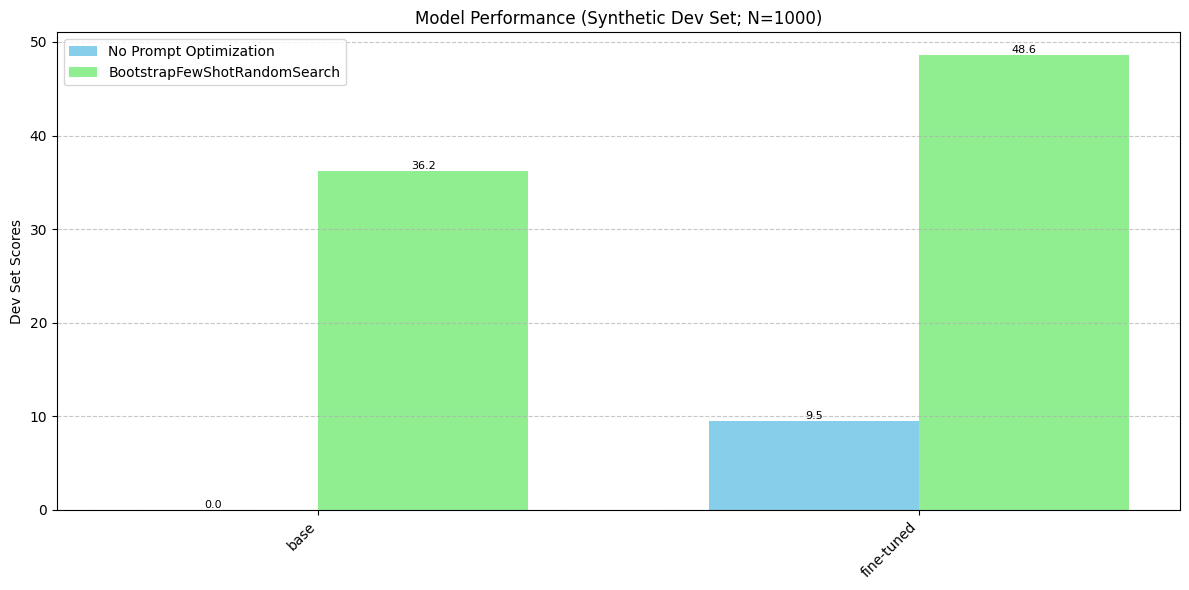

Highest Dev Set Score: 48.6, Model: fine-tuned


In [34]:
from src import graph_devset_results, graph_testset_results

graph_devset_results(ft_results)

We see that the our finetuned model significantly outperforms the base model on the synthetic devset, even when prompt optimized.

We will now evaluate both the finetuned and base models on the real test set to see if we have improved performance. We will use the prompt optimized versions of the models that we created using the synthetic devset as our in context examples.

This should take around 10 minutes to run.

In [36]:
%%capture
# Now we need to evaluate the test set
from src import run_testset_evaluation

testset_evaluation_kwargs = {
    "ft_results": ft_results,
    "all_llamas": all_llamas,
    "labels_in_use": labels_in_use,
    "testset": testset,
    "metric": adjusted_exact_match,
    "module_class": IntentClassificationModule
}

ft_results_testset, (best_program_path, best_model, best_score) = run_testset_evaluation(**testset_evaluation_kwargs)

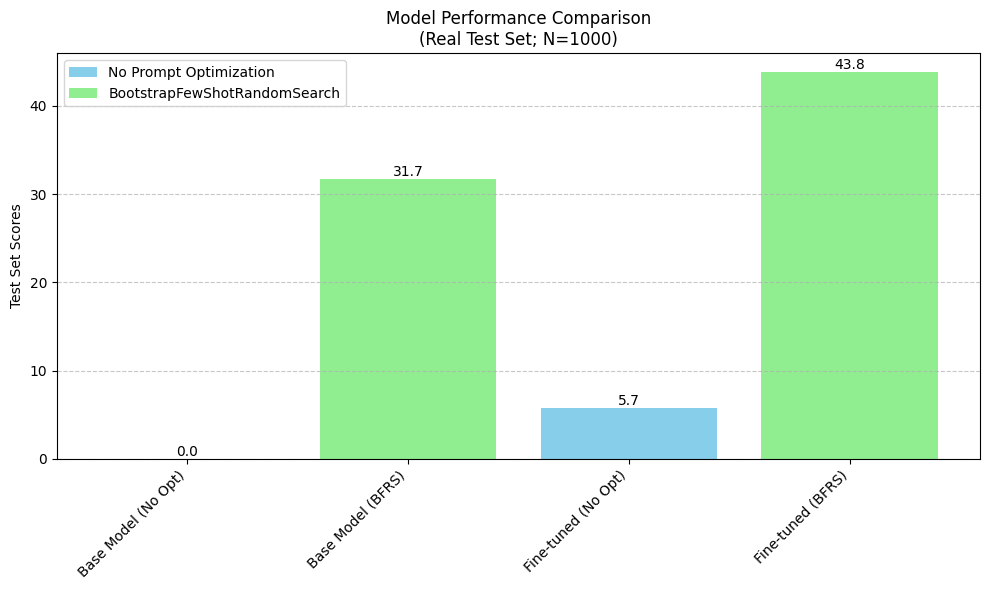

In [37]:
graph_testset_results(ft_results_testset)

In [38]:
print(f"Best testset result: \n{best_model} with score: {best_score}")

Best testset result: 
ft with score: 43.8


# Serving

# TODO: Add context about what we are doing

<b style="background-color: blue;">&nbsp;🔄 RUN (optional)&nbsp;</b>:
You can optionally deploy your model to Anyscale in order to use it in production.
To do this, run the following command:

```
!anyscale service deploy -f serve_1B.yaml
```

Follow the URL in order to find your service URL and API key for your deployed service.

If you choose not to deploy your model, you can run the following code to run the model locally.
```
serve run serve_1B.yaml
```

If you never took down your service from the previous section, there is no need to rerun the service run command.

In [ ]:
# !anyscale service deploy -f serve_1B.yaml
# !serve run serve_1B.yaml

<b style="background-color: yellow;">&nbsp;🔄 REPLACE&nbsp;</b>:
Replace the following variables with your Anyscale service URL and API key.

```
ANYSCALE_SERVICE_BASE_URL = None
ANYSCALE_API_KEY = None
```

You can find them by clicking the query button on the Anyscale dashboard for your service.

<!-- <img src="files/service-query.png" alt="Service Query" width="500"> -->
![Service Query](README_files/service-query.png)

In [39]:
ANYSCALE_SERVICE_BASE_URL = None
ANYSCALE_API_KEY = None

In [40]:
from src import MODEL_PARAMETERS, LOCAL_API_PARAMETERS
if ANYSCALE_SERVICE_BASE_URL and ANYSCALE_API_KEY:
    API_PARAMETERS = {"api_base": ANYSCALE_SERVICE_BASE_URL, "api_key": ANYSCALE_API_KEY}
else:
    API_PARAMETERS = LOCAL_API_PARAMETERS

The typical usecase for DSPy is for optimizing prompts and weights programmatically. DSPy allows you to define a complex pipeline with different components like a retriever and one or more LLMs. Often, we're interested in taking the same system we optimized during training to inference. 

To deploy, we recommend you serve the optimized DSPy program directly: This is the simplest option to take your program to production. Since DSPy simply relies on a deployed inference endpoint for LLM calls, we can use it in conjunction with optimized serving libraries like RayLLM. We can leverage Ray Serve with our DSPy pipeline being our custom business logic while serving.

NOTE: As of DSPy 2.5, there are scalability limitations for extremely high throughput scenarios with DSPy. DSPy compiled programs currently use threading for handling multiple queries in parallel, which might not scale as well as a native `async` implementation. A native `async` implementation is in the immediate roadmap for DSPy.

In [41]:
from ray import serve
from fastapi import FastAPI

app = FastAPI()

@serve.deployment(
    ray_actor_options={"num_cpus": 0.1},
    autoscaling_config=dict(min_replicas=1, max_replicas=3)
)
@serve.ingress(app)
class LLMClient:
    def __init__(self):
        self.llm = dspy.LM(model="openai/" + best_model, **MODEL_PARAMETERS, **API_PARAMETERS)
        dspy.settings.configure(experimental=True, lm=self.llm)
        self.program = IntentClassificationModule(labels_in_use)
        self.program.load(best_program_path)

    @app.get("/")
    async def classify_intent(
        self,
        query: str,
    ):
        """Answer the given question and provide sources."""
        retrieval_response = self.program(query)

        return retrieval_response.label

llm_client = LLMClient.bind()
llm_handle = serve.run(llm_client, route_prefix="/classify_intent", name="llm_client")

In [ ]:
example_query = ft_trainset[1]["text"]
llm_response = await llm_handle.classify_intent.remote(
    query=example_query,
)
print(example_query)
print(llm_response)

We can also query directly using HTTP requests, because we use the `@app` decorator on our FastAPI app.

In [ ]:
import requests
try:
    response = requests.get(f"http://localhost:8000/classify_intent?query={example_query}")
    print(response.json())
except Exception as e:
    print(e)

<b style="background-color: yellow;">&nbsp;🛑 IMPORTANT&nbsp;</b>: Please `Terminate` your service from the Service page to avoid depleting your free trial credits.

In [ ]:
# Clean up
!python src/clear_cell_nums.py
!find . | grep -E ".ipynb_checkpoints" | xargs rm -rf
!find . | grep -E "(__pycache__|\.pyc|\.pyo)" | xargs rm -rf
!rm -rf __pycache__ data .HF_TOKEN deploy/services